# COLOREADO DE GRAFOS USANDO SAT, MINIZINC Y NETWORKX

**GRUPO 1 --> José María, Prashant**

Los resolutores utilizados son: "Minizinc", un resolutor "SAT" llamado "Sparrow" extraído de la competición "SAT" del año 2018, éste se puede conseguir en el siguiente enlace: http://sat2018.forsyte.tuwien.ac.at/solvers/main_and_glucose_hack/, y, finalmente, se empleó la librería "Networkx" para crear un grafo y aplicarle un algoritmo "Greedy" 
alojado en esta misma librería.

El siguiente código se ha dividido en dos partes principales atendiendo al número de aristas de cada fichero, donde cada parte se resuelve con un resolutor específico, y, a su vez,
una de esas partes está dividido en dos subpartes. El motivo de esta división es que "Minizinc", que es capaz de obtener unos resultados óptimos, tarda más tiempo cuanto mayor sea
el número de aristas del fichero, por ello se procede a usar el resolutor "Sparrow" transformando este problema en un problema "SAT", y así, poder resolverlo usando claúsulas CNF. 
Sin embargo, al igual que "Minizinc", este resolutor empieza a demorar más tiempo, por lo que la alternativa a los ficheros más grandes (más de 100000 aristas) es usar un algoritmo
avaricioso (Greedy), proporcionado por la librería "Networkx". 

In [ ]:
import collections
from itertools import combinations
import subprocess # Se utiliza esta librería para poder ejecutar el solver "Sparrow" en la CLI de Linux.

import os
for dirname, _, filenames in os.walk('/kaggle/input/coloreado-de-grafos/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import csv
from IPython.display import FileLink
def submission_generation(filename, str_output):
    os.chdir(r'/kaggle/working')
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for item in str_output:
            writer.writerow(item)
    return  FileLink(filename)

In [ ]:
def check_solution(edges, solution):
    for edge in edges:
        if solution[edge[0]] == solution[edge[1]]:
            print("solución inválida, dos nodos adyacentes tienen el mismo color")
            return 0
    value = max(solution) + 1  # add one because minimum color is 0

    return value

**OBTENCIÓN DE MINIZINC**

Para poder utilizar "Minizinc", primero hay que obtenerlo, para ello se obtiene dicha librería desde el siguiente enlace:
https://github.com/MiniZinc/MiniZincIDE/releases/download/2.3.2/MiniZincIDE-2.3.2-bundle-linux-x86_64.tgz

Primero se debe eliminar, si es que existiera, la carpeta y el fichero comprimido que contienen la librería, de ese modo no habrá 
conflictos a la hora de obtener el resolutor. Posteriormente se extrae "Minizinc", para que, finalmente, se puedan configurar
las respectivas variables de entorno asociadas a "Minizinc".

In [ ]:
%%bash
rm MiniZincIDE-2.3.2-bundle-linux-x86_64.tgz
rm -r MiniZincIDE-2.3.2-bundle-linux
wget https://github.com/MiniZinc/MiniZincIDE/releases/download/2.3.2/MiniZincIDE-2.3.2-bundle-linux-x86_64.tgz
tar xf MiniZincIDE-2.3.2-bundle-linux-x86_64.tgz

In [ ]:
%set_env PATH=/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:MiniZincIDE-2.3.2-bundle-linux/bin
%set_env LD_LIBRARY_PATH=/opt/conda/lib:MiniZincIDE-2.3.2-bundle-linux/lib
%set_env QT_PLUGIN_PATH=MiniZincIDE-2.3.2-bundle-linux/plugins

**TRANSFORMACIÓN DE COLOREADO DE GRAFOS A SAT**

Para poder aplicar un resolutor de "SAT" a este problema, lo primero que se debe hacer es realizar una serie de conversiones para
obtener las distintas claúsulas que conformarán el fichero CNF, ya que estos resolutores funcionan de esa manera. 

Un fichero CNF es aquel que contiene varias claúsulas unidas por conjunciones (AND), donde cada una de estas claúsulas está compuesto
a su vez por varios literales separados por disyunciones (OR) --> Ejemplo: (A or B or (not C)) and (B or (not A))...
En este fichero los literales son representados por enteros empezando por 1, y si existen literales negados, simplemente se añade "-1",
además, cada claúsula se sitúa en cada línea del fichero donde los literales se separan por espacios, y esta línea debe terminar con un 0.

Este fichero tiene unas cabeceras de comentarios expresados con una "c" al inicio de cada línea, y un resumen del número de claúsulas y el 
de literales expresado con una "p" al inicio de esta línea, de este modo, el fichero adopta la siguiente forma:

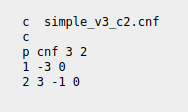

Una vez explicado este fichero, se procede a clasificar en 3 los tipos de claúsulas posibles para la trasnformación de Coloreado de Grafos a 
SAT, el número de clasúsulas resultantes vendrá regido por la cantidad de colores que se le asigne, esto es debido a que "SAT" devuelve un 
resultado booleano que afirma o niega si las claúsulas pueden ser satisfacibles o no. Por este motivo, antes de aplicar esta conversión, se 
obtiene una estimación de la cantidad de colores usando "Minizinc" pero sin obtener los óptimos, aplicando "indomain_min" y "most_constrained".

La respuesta de cada uno de estos tres métodos es una "string" que contiene una lista de claúsulas donde los "or" son representados por "+", y
los "and" por ",", además que cada claúsula está limitada por paréntesis "()", y las negaciones por "!". El número de literales viene determinado 
por el número de nodos y el número de colores asignado (n_nodos * n_colores), cada literal está constituido de dos partes, un identificativo 
del nodo junto a un identificativo al color con el que se intentará pintar este nodo --> (0_1), ¿nodo 0 será pintado con color 1?

**El formato se decidió de esta manera para que estas claúsulas sean compatibles y puedan ser resueltas por una serie de resolutores "SAT" que 
pertenecen a otro proyecto nuestro, que puede ser encontrado en github como:**

https://github.com/Prashant-JT/BooleanSatisfiabilityProblem
https://github.com/JoseMAP-99/MultiSAT

Para obtener la "string" con todas las claúsulas correspondientes, se ha de llamar a este método pasándole las aristas, el número de nodos existentes
y la cantidad de colores a usar, cada llamada los tipos de claúsulas devuelve otra "string" de claúsulas de ese mismo tipo, por lo que deberá añadirse
a la "string" principal con un "and" como ",".

Para la tranformación en "SAT", se obtuvo ayuda de: 

https://www.researchgate.net/publication/268460124_Satisfiability_Methods_for_Colouring_Graphs/fulltext/5721424d08ae0926eb45bd3f/Satisfiability-Methods-for-Colouring-Graphs.pdf

In [ ]:
def getTypes(edges, node_count, color):
    """
        Tipo 1 -> nColor*nEdges --> 2*3=6 claúsulas
            (!0_0 + !1_0), (!0_1 + !1_1)
            (!1_0 + !2_0), (!1_1 + !2_1)
            (!1_0 + !3_0), (!1_1 + !3_1)
        Tipo 2 -> 4 nodos --> 4 claúsulas
            (0_0 + 0_1)
            (1_0 + 1_1)
            (2_0 + 2_1)
            (3_0 + 3_1)
        Tipo 3 -> nColor*nNodes --> 2*4=8 claúsulas
            (!0_0 + !0_1)
            (!1_0 + !1_1)
            (!2_0 + !2_1)
            (!3_0 + !3_1)
        18 clausulas
    """
    clType = type1(edges, color) + "," + type2(node_count, color) + "," + type3(node_count, color)

    return clType

**TIPO 1**

El número de claúsulas de este tipo viene determinado por el número de colores elegido y el número de aristas (n_color * n_aristas).
Este tipo de claúsula restringe que dos nodos adyacentes tengan el mismo color, por ejemplo:

(!0_0 + !1_0), (!0_1 + !1_1) 

Primero se deduce que el nodo 0 comparte arista con el nodo 1, y que existen 2 colores (0, 1), y que se trata de 4 literales distintos, 2 de ellos
pertenecientes al nodo 0 y las otras dos al nodo 1. Por ejemplo, en la primera claúsula se restringe que se pinte de color 0 únicamente uno de los 
dos nodos (0, 1), y lo mismo en la siguiente claúsula, pero usando el color 1.

In [ ]:
def type1(edges, color):
    """
    Tipo 1 -> nColor * nEdges --> 2 * 3 = 6 claúsulas
    (!0_0 + !1_0), (!0_1 + !1_1) 
    (!1_0 + !2_0), (!1_1 + !2_1)
    (!1_0 + !3_0), (!1_1 + !3_1)
    """

    clausulas = ""

    for i, f in edges:
        for x in range(0, color):
            clausulas += "(!" + str(i) + "_" + str(x) + "+!" + str(f) + "_" + str(x) + "),"
    return clausulas[:-1]

**TIPO 2**

El número de claúsulas de este tipo viene determinado únicamente por el número de nodos, sin embargo, el número 
de literales viene determinado por el número de colores.
Este tipo de claúsula obliga a que todos y cada uno de los nodos sea pintado por algún color, por tanto, mientras 
el número de colores sea mayor, el número de literales por claúsula será mayor, por ejemplo:

(0_0 + 0_1)

De esta claúsula, se puede deducir que existen 2 colores, y que se trata del nodo 0. Por tanto, este nodo 0 debe ser
pintado obligatoriamente por aluno de esos dos colores, 0 o 1.

In [ ]:
def type2(nodes, color):
    """
    Tipo 2 -> 4 nodos --> 4 claúsulas
    (0_0 + 0_1)
    (1_0 + 1_1)
    (2_0 + 2_1)
    (3_0 + 3_1)
    """

    clausulas = ""
    for n in range(0, nodes):
        clausulas += "("
        for x in range(0, color):
            clausulas += str(n) + "_" + str(x) + "+"
        clausulas = clausulas[:-1] + "),"
    return clausulas[:-1]


**TIPO 3**

El númeo de claúsulas de este tipo viene determinado por el número de nodos y el número de colores (n_color * n_nodos).
Este tipo de claúsula asegura que un nodo sea pintado únicamente con un color, para realizar esto, se debe realizar una
combinación sin repetición de 2 elementos, para ello se utiliza "itertools.combinations(list, 2)" donde se aplica:

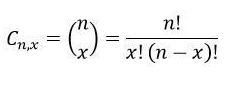

Una claúsula de ejemplo:

(!0_0 + !0_1), (!0_0 + !0_2), (!0_1 + !0_2)

De esta claúsula se deduce que existen 3 colores, y que se trata del nodo 0. Por tanto, en la primera claúsula, el nodo 0 
sólo puede ser pintado por el color 1 o el color 0, y lo mismo en el resto de claúsulas de este nodo.
Este método se dividió en 2, dado que cuando el número de colores es 2, es decir, color 0 y 1, no hace falta crear combinaciones,
dado que cada nodo sólo puede coger 1 color de entre 2.

In [ ]:
def type3(nodes, color):
    """
    Tipo 3 -> nColor * nNodes --> 3 * 4 = 12 claúsulas
    (!0_0 + !0_1), (!0_0 + !0_2), (!0_1 + !0_2)
    (!1_0 + !1_1), (!1_0 + !1_2), (!1_1 + !1_2)
    (!2_0 + !2_1), (!2_0 + !3_2), (!2_1 + !2_2)
    (!3_0 + !3_1), (!3_0 + !3_2), (!3_1 + !3_2)
    """

    clausulas = ""
    if color > 2:
        for n in range(0, nodes):
            for x, y in combinations(range(0, color - 1), 2):
                clausulas += "(!" + str(n) + "_" + str(x) + "+!" + str(n) + "_" + str(y) + "),"
    else:
        for n in range(0, nodes):
            clausulas += "(!" + str(n) + "_0+!" + str(n) + "_1),"

    return clausulas[:-1]

**TRANSFORMACIÓN DE FÓRMULA PERSONALIZADA A CNF**

Una vez se ha obtenido la "string" con todas las claúsulas con el formato (!0_0+!0_1),(1_0+1_1)..., se
procede a transformar esta fórmula al formato adecuado de los ficheros CNF, para ello se guarda en un 
diccionario las transformaciones de los literales, de tal modo que queda un diccionario de la siguiente forma:

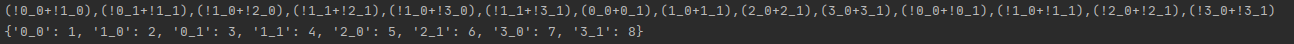

Donde la primera línea representa la "string" con todas las claúsulas para un fichero de 4 nodos y 2 colores, se 
puede apreciar que las claúsulas se sitúan en orden, primero las de tipo 1, tipo 2 y terminando con las de tipo 3.
Además, se aprecia que existen 3 aristas, si contamos las de tipo 1 atendiendo si pertenecen al mismo par de nodos.

Y se aprecia que el diccionario tiene 8 claves, esto se puede deducir analizando las claúsulas de tipo 2, dado que
para cada nodo, se crea un literal distinto con cada color. Los valores del diccionario son sus respectivas equivalencias
con enteros para que sea más fácil la conversión una vez obtenido el resultado del resolutor.

Se puede apreciar que se devuelve un diccionario invertido, esto es importante para facilitar la obtención de literales de
coloreado de grafos usando como clave los literales CNF, todo ello usado en la posterior conversión.

In [ ]:
def parserFormula(formula):
    litDict = {}
    clauses = []

    cont = 1
    for cl in formula.split(','):
        auxC = ""
        for a in cl[1:-1].split('+'):
            b = a.replace("!", "")
            if b not in litDict:
                litDict[b] = cont
                cont += 1
            auxC += (str(litDict[b]) + " " if a[0] != "!" else str(-litDict[b]) + " ")
        clauses.append([auxC + "0"])

    return dict(zip(litDict.values(), litDict.keys())), clauses

**CREANDO EL FICHERO MZN**

Una vez se ha instalado "Minizinc", se procede a usar "pymzn", un puente entre este resolutor y Python. Para usar 
esta herramienta es necesario proporcionar un fichero ".mzn" con el código de "Minizinc", para hacer esto más simple,
se genera un "string" con este código, y posteriormente se inserta en un fichero usando "file.write()", se devuelve 
la ruta de este fichero, la misma que se proporcionó al método.

El código de "Minizinc" se divide en dos, para aquellos ficheros con menos de 1200 aristas, se obtendrá el óptimo usando
"minimize max(Des)". Y para aquellos mayores de 1200, se aplica un "solve" que proporciona resultados factibles que servirán
como una aproximación al número de colores, esto es requerido por el resolutor "Sparrow".

In [ ]:
!pip install pymzn
import pymzn

def passMzn(path, edge_count):
    string = """
        include "globals.mzn";
        int: e;
        int: n;
        int: m;
        set of int: nodes = 0..m;
        array[1..e, 1..2] of int: edges;
        array[0..n] of var nodes: Des;
        
        constraint forall(i in 1..e)(Des[edges[i,1]] != Des[edges[i,2]]);  
        """
    if edge_count > 1200:
        string += "solve :: int_search(Des, most_constrained, indomain_min) satisfy;"
    else:
        string += """
        constraint forall(x, y in 0..n where y = x+1)(value_precede(x, y, Des));
            
        solve minimize max(Des);
        """
    with open(path, "w") as file:
        file.write(string)

    return path

**APLICANDO GREEDY CON NETWORKX**

Para todos aquellos ficheros que posean más de 100000 aristas, se emplea un algoritmo Greedy ya desarrollado
en esta librería, aplicando la estrategia "independent_set", dado que se obtuvo mejores resultados con ésta.

Para poder aplicar esto, primero se debe crear el grafo, para luego añadirle las aristas que ya viene en formato
de una lista con tuplas, entonces, simplemente se llama al método greedy_color(). Este método devuelve un 
diccionario en el que las claves representan los nodos, y los valores el color con el que debería pintarse cada
uno de esos nodos.



Posteriormente se obtiene vector "taken" que especifica lo mismo que el diccionario, pero en el que las claves
pasan a ser las posiciones del vector.

In [ ]:
!pip install networkx
from networkx import algorithms, Graph

def greedyColor(edgesX, node_countX):

    G = Graph()
    G.add_edges_from(edgesX)
    
    res = algorithms.coloring.greedy_color(G, strategy='independent_set')

    taken = [0]*node_countX
    for key, value in res.items():
        taken[key] = value
    return taken

**INSTALANDO SPARROW SAT**

Al igual que se descargó "Minizinc", se debe descargar este resolutor, aplicando los mismo mecanismos
que fueron explicados arriba.

Algo que destacar es que se crean dos carpetas, esto se para no ensuciar el entorno, dado que este resolutor
genera ficheros que irán a parar en ./Temporales.
Y la carpeta ./CNF se crea con el fin de almacenar todos los ficheros CNF generados por este programa.

In [ ]:
%%bash
rm Sparrow2Riss-2018.zip
rm -fr Sparrow2Riss-2018-fixfix
wget http://sat2018.forsyte.tuwien.ac.at/solvers/main_and_glucose_hack/Sparrow2Riss-2018.zip
unzip Sparrow2Riss-2018.zip
mkdir -p /kaggle/working/Temporales
mkdir -p /kaggle/working/CNF

**RESOLVIENDO EL PROBLEMA**

Una vez se ha obtenido la lista de aristas, donde cada elemento es una tupla de nodo inicial y nodo final, 
se procede a clasificar el problema según el número de aristas.

Se aplicará "Minizinc" a todos aquellos ficheros que tengan menor de 100000 aristas usando el comando 
"pymzn.minizinc()", al que se le pasa la ruta del fichero ".mzn" y las respectivas equivalencias del modelo
con nuestras variables. El resultado de esto es una lista en la que cada posición representa algún nodo, y el
valor de esta posición, el color con el que debería ser pintado. Se calcula el número de colores total llamando
al método "check_solution()", qué además comprobará si es correcto.

Si el número de aristas es mayor a 1200, entonces sólo se ha obtenido una aproximación al valor óptimo, por lo 
que se aplicará el resolutor "Sparrow", para ello primero se debe generar el fichero CNF. 

Se define un método interno "createCNF(). Lo primero que hace este método es llamar a "getTypes()", pasándole la lista
de aristas, el número de nodos, **y la estimación del número de color menos uno**, ya que habrá que comprobar si es satisfacible
o no con un color menos, el método al que se llama devuelve una "string" con todas las claúsulas, esta "string" será 
transformada al formato CNF, que devuelve un diccionario de equivalencias y una lista de las claúsulas. Lo siguiente 
será crear el fichero CNF con este contenido, para finalmente devolver la ruta del fichero CNF y el diccionario de equivalencias.

Se crea un bucle "infinito", cuyas salidas serán cuando el proceso creado demore más de 30 segundos, o cuando este
proceso devuelva un error o cuando la claúsula sea insatisfacible.

Lo primero que se realiza en este bucle es llamar el método "createCNF()", para posteriormente crear un proceso en CLI
que ejecutará el resolutor "Sparrow" con el fichero recibido de "createCNF()", la ejecución es de la forma:

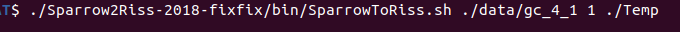

Donde el primer parámetro es el ejecutable, el segundo es el fichero CNF, el tercero es la semilla y el cuarto es el directorio
donde se almacenarán los ficheros creados por este resolutor.

La respuesta obtenida de este proceso tiene la siguiente forma, donde lo que importa son lo últimos parámetros:

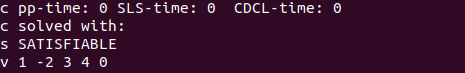

Esta respuesta viene en un "array" de bytes, por lo que se procede a decodificarla en "UTF-8", y partirlo por saltos de línea. 
El elemento "s SATISFIABLE" o "s UNSATISFIABLE" de esta lista siempre ocupa la posición -3, por lo que se verifica si se obtuvo
o no esta respuesta, para salir o no del bucle.

Lo siguiente es obtener el vector resultado, que especifica que claúsulas son verdaderas y cuáles no, con lo que ya se puede 
reconvertir la solución de "SAT" a Coloreado de Grafos, usando el diccionario de equivalencias, donde se atiene sólo a aquellas
claúsulas positivas (Verdaderas). Una vez obtenido el vector "taken", se obtiene el número total de colores.

Finalmente, se vuelve a iterar con los valores de "taken" y "solution" actualizados.


Para todos aquellos ficheros con un número de aristas mayor o igual a 100000 se llama al método "greedy", obteniendo un "taken",
para posteriormente pasárselo al método "check_solution()" y obtener el número de colores total.

In [ ]:
def solve_it(input_data):
    # Modify this code to run your optimization algorithm

    # parse the input
    lines = input_data.split('\n')

    first_line = lines[0].split()
    node_count = int(first_line[0])
    edge_count = int(first_line[1])

    edges = []
    for i in range(1, edge_count + 1):
        line = lines[i]
        parts = line.split()
        edges.append((int(parts[0]), int(parts[1])))
   
    if edge_count < 100000:
        
        freq = collections.Counter(t[0] for t in edges)
        maximo = max(freq.values()) + 1

        a = pymzn.minizinc(passMzn("/kaggle/working/graphcoloring.mzn", edge_count), data={'e': edge_count,
                                                                                           'n': node_count - 1,
                                                                                           'm': maximo,
                                                                                           'edges': edges})

        taken = list(a[0].get('Des').values())
        solution = check_solution(edges, taken)
        
        if edge_count > 1200:

            def createCNF():
                auxT = getTypes(edges, node_count, solution-1)
                litDict, cnf = parserFormula(auxT)

                text = [["p cnf " + str(len(litDict.keys())) + " " + str(len(cnf))]]
                text.extend(cnf)
                name = "/kaggle/working/CNF/n" + str(node_count) + "_e" + str(edge_count) + ".cnf"
                submission_generation(name, text)
                return name, litDict

            while True:
                nam, dictResU = createCNF()
                run = "/kaggle/working/Sparrow2Riss-2018-fixfix/bin/SparrowToRiss.sh " + nam + " 1 /kaggle/working/Temporales"
                process = subprocess.Popen(run.split(), stdout=subprocess.PIPE)
                try:
                    process.wait(timeout=30)
                except subprocess.TimeoutExpired:
                    try:
                        os.kill(process.pid, 0)
                    finally:
                        break
                output, error = process.communicate()
                if error:
                    print("Oh no! ERROR")
                    break
                res = output.decode("utf-8").split("\n")
                sat = True if res[-3] == "s SATISFIABLE" else False
                if not sat:
                    break
                sol = res[-2]
                vectSol = [int(x) for x in sol[1:-1].split()]

                taken = [0] * node_count
                for x in vectSol:
                    if x > 0:
                        aux = dictResU.get(x).split("_")
                        taken[int(aux[0])] = int(aux[1])
                solution = check_solution(edges, taken)
        
    
    else:
        taken = greedyColor(edges, node_count)
        solution = check_solution(edges, taken)
    
    # prepare the solution in the specified output format
    output_data = str(node_count) + ' ' + str(0) + '\n'
    output_data += ' '.join(map(str, taken))

    return output_data, solution

In [ ]:
str_output = [["Filename","Min_value"]]

for dirname, _, filenames in os.walk('/kaggle/input/coloreado-de-grafos'):
    for filename in filenames:
        full_name = dirname+'/'+filename
        with open(full_name, 'r') as input_data_file:
            input_data = input_data_file.read()
            output, value = solve_it(input_data)
            str_output.append([filename,str(value)])
        print(filename, value)

In [ ]:
submission_generation('Grupo1_ColorGraph_SAT.csv', str_output)